In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

In [206]:
dataset = pd.read_csv(r"C:\Users\CEA\Documents\Python Scripts\default.csv")

In [207]:
dataset.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [208]:
target = dataset['default payment next month']
data = dataset.drop(['ID','default payment next month'], axis=1)

In [209]:
print('target shape = ', target.shape)
print('data shape = ', data.shape)
print('dataset shape = ', dataset.shape)

target shape =  (30000,)
data shape =  (30000, 23)
dataset shape =  (30000, 25)


In [210]:
data.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64

In [211]:
pd.isnull(target).sum()

0

In [212]:
target

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default payment next month, Length: 30000, dtype: int64

In [213]:
data.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
dtype: object

In [214]:
xtrain, xtest, ytrain, ytest= train_test_split(data, target, train_size = 0.8, random_state=2)
x_train, x_val, y_train, y_val= train_test_split(xtrain,ytrain, train_size= 0.8, random_state=2)


In [215]:
print('train size', x_train.shape, y_train.shape)
print('val size', x_val.shape, y_val.shape)
print('test size', xtest.shape, ytest.shape)

train size (19200, 23) (19200,)
val size (4800, 23) (4800,)
test size (6000, 23) (6000,)


In [216]:
scalar= StandardScaler().fit(x_train)
x_train_scaled= scalar.transform(x_train)
xtest_scaled = scalar.transform(xtest)
x_val_scaled = scalar.transform(x_val)

In [217]:
# defining a function for deep neural network
def seqmodel (arr):
    model = Sequential()
    for i in range(len(arr)):
        if i!=0 and i!= len(arr)-1:
            if i==1:
                model.add(Dense(arr[i], input_dim= arr[0], activation='relu'))
            else:
                model.add(Dense(arr[i], activation='relu'))
    model.add(Dense(arr[-1], activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model

In [218]:
# defining a function for model evaluation

def eval_model(model,XTRAIN,YTRAIN,XVAL,YVAL,XTEST,YTEST):
    history = model.fit(np.array(XTRAIN),np.array(YTRAIN), epochs=40, validation_data= (XVAL, YVAL), verbose=0)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    print('\n loss validation dataset', history.history['val_loss'])
    print('\n Accuracy validation dataset', history.history['val_accuracy'])
    
    predY= model.predict(np.array(XTEST))
    predY=np.round(predY).astype(int).reshape(1,-1)[0]
    m= confusion_matrix(predY, YTEST)
    tn,fn,fp,tp = m.ravel()
    m= pd.crosstab(predY,YTEST)
    print('\n Tabular data evaluation (confussion matrix)')
    print(m)
    
    sens=tp/(tp+fn)
    spec=tn/(tn+fp)
    prec=tp/(tp+fp)
    acc=(tp+tn)/(tp+tn+fp+fn)
    f1=f1_score(YTEST,predY)
    auc=roc_auc_score(YTEST,predY)
    print("\nModel Validation")
    print("Senstivity : ",sens)
    print("Specificity : ",spec)
    print("Precision : ",prec)
    print("Accuracy : ",acc)
    print("F1 score : ",f1)
    print("AUC : ",auc)


In [219]:
model_one = seqmodel([23,30,20,1])

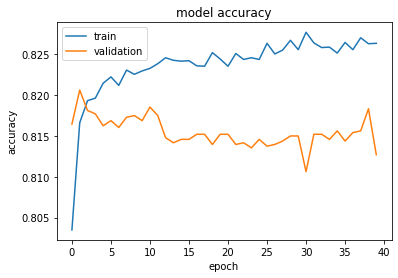


 loss validation dataset [0.4547910690307617, 0.4491249620914459, 0.448632150888443, 0.44360238313674927, 0.4423615038394928, 0.4461272060871124, 0.44540563225746155, 0.446768581867218, 0.44402867555618286, 0.4416678249835968, 0.44291937351226807, 0.44342100620269775, 0.44193190336227417, 0.446022629737854, 0.44727396965026855, 0.44353199005126953, 0.44381964206695557, 0.43964290618896484, 0.4434336721897125, 0.4397819936275482, 0.44044244289398193, 0.4415038526058197, 0.4409286081790924, 0.44169026613235474, 0.44149526953697205, 0.4430086314678192, 0.4421119689941406, 0.4420204758644104, 0.4417388439178467, 0.44149285554885864, 0.4451265335083008, 0.44764918088912964, 0.4392649233341217, 0.4428790807723999, 0.4400498867034912, 0.4414067566394806, 0.44329696893692017, 0.44151926040649414, 0.4470026195049286, 0.44435715675354004]

 Accuracy validation dataset [0.8164583444595337, 0.8206250071525574, 0.8181250095367432, 0.8177083134651184, 0.8162500262260437, 0.8168749809265137, 0.81604

In [220]:
eval_model(model_one,x_train_scaled,y_train,x_val_scaled,y_val,xtest_scaled,ytest)

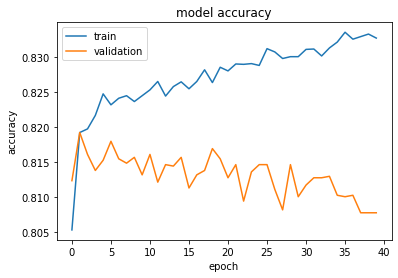


 loss validation dataset [0.45544198155403137, 0.44907012581825256, 0.4473734498023987, 0.44766587018966675, 0.4509925842285156, 0.44589629769325256, 0.4431503713130951, 0.44327789545059204, 0.44140151143074036, 0.44205617904663086, 0.44369593262672424, 0.44472426176071167, 0.4436069130897522, 0.4424518346786499, 0.4437268078327179, 0.4450915455818176, 0.4432372450828552, 0.44649478793144226, 0.44795867800712585, 0.4450685679912567, 0.44510728120803833, 0.44409796595573425, 0.449470579624176, 0.4558938145637512, 0.4470142126083374, 0.45129817724227905, 0.4520103335380554, 0.4496757388114929, 0.4518948793411255, 0.44848698377609253, 0.4514937400817871, 0.4515748620033264, 0.4523789882659912, 0.45830681920051575, 0.4589499533176422, 0.46142110228538513, 0.45921629667282104, 0.4615024924278259, 0.45832595229148865, 0.4610140025615692]

 Accuracy validation dataset [0.81229168176651, 0.8191666603088379, 0.8160416483879089, 0.8137500286102295, 0.8152083158493042, 0.8179166913032532, 0.8154

In [221]:
model_two = seqmodel([23,50,30,20,1])
eval_model(model_two,x_train_scaled,y_train,x_val_scaled,y_val,xtest_scaled,ytest)

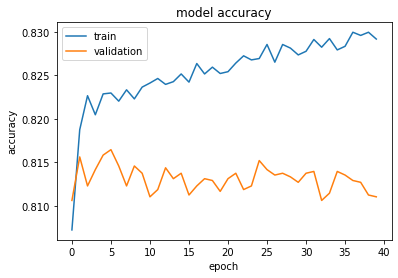


 loss validation dataset [0.4572426974773407, 0.44995981454849243, 0.449796587228775, 0.44598516821861267, 0.44642242789268494, 0.4448501169681549, 0.44299495220184326, 0.4438149631023407, 0.4456571936607361, 0.4444520175457001, 0.4447079002857208, 0.44478875398635864, 0.44482722878456116, 0.44914519786834717, 0.44645461440086365, 0.45248478651046753, 0.44677743315696716, 0.4456353783607483, 0.44648274779319763, 0.4470468759536743, 0.44919800758361816, 0.44898727536201477, 0.44810616970062256, 0.451210618019104, 0.4495643079280853, 0.44941771030426025, 0.44638413190841675, 0.4478835463523865, 0.4500178396701813, 0.4549645483493805, 0.44913700222969055, 0.44933024048805237, 0.4534495174884796, 0.4511640965938568, 0.4483938217163086, 0.45445603132247925, 0.4508146047592163, 0.4543832838535309, 0.4523375928401947, 0.4568015933036804]

 Accuracy validation dataset [0.8106250166893005, 0.815625011920929, 0.81229168176651, 0.8141666650772095, 0.815833330154419, 0.8164583444595337, 0.8145833

In [222]:
model_three = seqmodel([23,50,30,1])
eval_model(model_three,x_train_scaled,y_train,x_val_scaled,y_val,xtest_scaled,ytest)

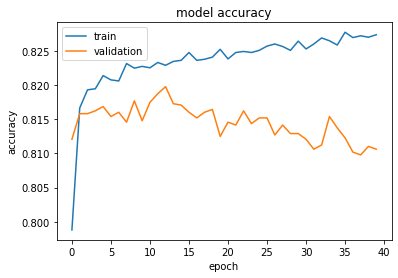


 loss validation dataset [0.46194177865982056, 0.4519364833831787, 0.44723862409591675, 0.44601526856422424, 0.4427478015422821, 0.4431363344192505, 0.443028062582016, 0.4460190236568451, 0.4422689378261566, 0.4424837827682495, 0.44073599576950073, 0.4448930323123932, 0.4438323974609375, 0.4426748752593994, 0.44333916902542114, 0.4421243369579315, 0.4418918788433075, 0.444243460893631, 0.44255995750427246, 0.4408133327960968, 0.442332923412323, 0.44219639897346497, 0.4419894516468048, 0.44324570894241333, 0.44337132573127747, 0.4407472312450409, 0.4413629174232483, 0.4407140016555786, 0.4428749680519104, 0.4431689381599426, 0.44352421164512634, 0.441726952791214, 0.44705086946487427, 0.4418846666812897, 0.44356510043144226, 0.4456896483898163, 0.44607308506965637, 0.4459967613220215, 0.44703954458236694, 0.4466860592365265]

 Accuracy validation dataset [0.8120833039283752, 0.815833330154419, 0.815833330154419, 0.8162500262260437, 0.8168749809265137, 0.815416693687439, 0.8160416483879

In [223]:
model_four = seqmodel([23,30,10,1])
eval_model(model_four,x_train_scaled,y_train,x_val_scaled,y_val,xtest_scaled,ytest)

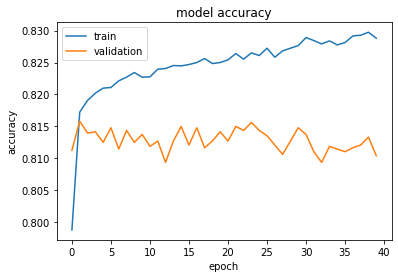


 loss validation dataset [0.4626328945159912, 0.452088862657547, 0.4513308107852936, 0.4478289783000946, 0.44885167479515076, 0.4443669021129608, 0.4445650279521942, 0.44616830348968506, 0.44533705711364746, 0.4428730905056, 0.4486439526081085, 0.4422043263912201, 0.44306620955467224, 0.44557327032089233, 0.4426616430282593, 0.4469951391220093, 0.44262635707855225, 0.44346094131469727, 0.44388434290885925, 0.44109785556793213, 0.4417940676212311, 0.44331833720207214, 0.44255533814430237, 0.44280704855918884, 0.44204720854759216, 0.44414830207824707, 0.4436594247817993, 0.4468437731266022, 0.44610723853111267, 0.4457104504108429, 0.4490242600440979, 0.4451959729194641, 0.4508962631225586, 0.4495735764503479, 0.4483546316623688, 0.44870346784591675, 0.447653204202652, 0.4540073573589325, 0.45217305421829224, 0.4494447708129883]

 Accuracy validation dataset [0.8112499713897705, 0.815833330154419, 0.8139583468437195, 0.8141666650772095, 0.8125, 0.8147916793823242, 0.8114583492279053, 0.8

In [224]:
model_five = seqmodel([23,40,20,1])
eval_model(model_five,x_train_scaled,y_train,x_val_scaled,y_val,xtest_scaled,ytest)